
# Analiza meteoroloških podatkov (vir : ARSO)
## Uvoz podatkov

Podatki so že prej bili naloženi s programoma <TT>prenos-identifikatorjev.py</TT> in <TT>podatki-posameznih-postaj.py</TT>, ki pa ju lahko poženemo tudi iz tega programa

Datoteka <TT>slovar.csv</TT> vsebuje povezavo med imenom postaje in njenim identifikatorjem. 

V <i>/postaje/</i> so datoteke s podatki posameznih postaj po imenih <TT>HXXXX_t_30.html.csv</TT>, kjer XXXX predstavlja identifikacijsko številko postaje.

In [38]:
%run prenos-identifikatorjev.py
#%run podatki-posameznih-postaj.py #zakomentirana vrstica, saj prenos podatkov posameznih postaj traja nekaj minut
#postaj je namreč 180 in vsaka vsebuje 1439 vrstic

In [56]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
import IPython
from ipywidgets import interact
import scipy
import pandas as pd

pd.options.display.max_rows = 30 #Koliko vrstic naenkrat prikaže pandas
pd.options.display.min_rows = 16
%matplotlib inline

In [57]:
slovar=[*csv.DictReader(open('slovar.csv'))] #odprem in shranim slovar od prej kot slovar tukaj

In [59]:
slovarpd = pd.read_csv("slovar.csv", encoding='mbcs', index_col="Ime") #če pustim encoding prazen, torej na utf-8 mi da error
slovarpd

,Reka,ID
Ime,,
Gornja Radgona I,Mura,H1060
Petanjci,Mura,H1070
Cankova,Kučnica,H1100
Pristava,Ščavnica,H1140
Nuskova,Ledava,H1165
Polana I,Ledava,H1220
Čentiba,Ledava,H1260
Martjanci,Martjanski potok,H1300
...,...,...


Zdaj lahko izberemo naključno vrsico iz slovarja in analiziramo podatke te postaje

In [79]:
izbrana_postaja = slovarpd.sample()
izbrana_postaja["ID"].tolist()

['H7498']

In [49]:
pd.options.display.max_rows

30

In [10]:
len(slovar)

180

In [14]:
def spremeni_v_float(seznam):
    """
    Funkcija, ki sprejme 2 dimenzionalen seznam (n,4) [datum, višina, pretok, temperatura] in vrne številčni 2d array [višina, pretok]

    Vsak "-" v drugem in tretjem stolpcu spremeni v -1, da lahko potem s seznamom upravljamo kot s števili
    """
    for indeks, i in enumerate(seznam):
        for jndeks, j in enumerate(i):
            if j=='-':
                seznam[indeks, jndeks]="-1"
    #print(list(np.asfarray(seznam[1])))
    novseznam = np.array([np.asfarray(seznam[1]), np.asfarray(seznam[2])])
    
                
    #seznam[1::, 1] = np.asfarray(seznam[1::, 1]) ni hotelo delati iz nekega razloga, zato grem na loope
    #seznam[1::, 2] = np.asfarray(seznam[1::, 2])
    #seznam[1::, 3] = np.asfarray(seznam[1::, 3])

    return novseznam 

In [15]:
def dobi_podatke(ID):
    """
    Funkcija, ki iz ID-ja pridobi tabelo za uporabo v spremeni_v_float
    """

    arry = np.loadtxt("postaje/" + ID + ".csv",
                 delimiter=",", dtype=str)

    arry = np.transpose(np.delete(arry, 0, 0))
    return arry

In [16]:
arr = dobi_podatke(slovar[3]["ID"])
arr = spremeni_v_float(arr)
n = len(arr[0])

In [17]:
arr

array([[52.   , 52.   , 52.   , ..., 75.   , 75.   , 74.   ],
       [ 0.648,  0.648,  0.648, ...,  1.55 ,  1.55 ,  1.5  ]])

In [18]:
order = np.argsort(arr[1::,1])
xs = np.array(arr[1::,1])[order][100:120]
ys = np.array(arr[1::,2])[order]
xs


array([], dtype=float64)

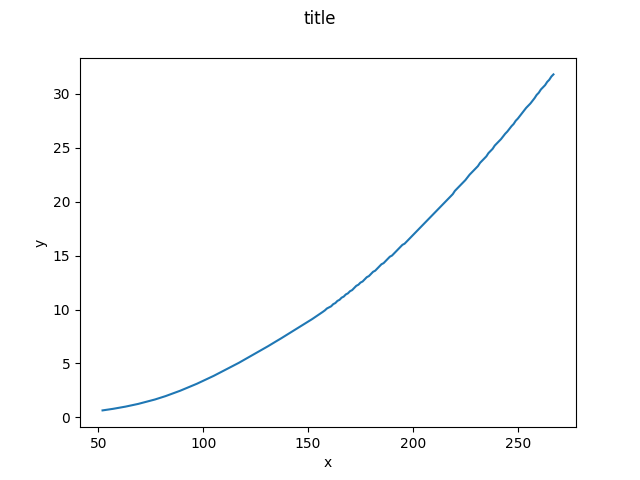

In [19]:
order = np.argsort(arr[0])
xs = np.array(arr[0])[order]
ys = np.array(arr[1])[order]

fig = plt.figure()
ax = plt.subplot()

fig.suptitle('title')
plt.xlabel('x')
plt.ylabel('y')

ax.plot(xs, ys, label='desc' )
plt.show()

In [20]:
fit = np.poly1d(np.polyfit(xs, ys, 2))
print(np.polyfit(xs, ys, 2))
x = np.linspace(-xs[-1], xs[-1], 200)
plt.plot(x, fit(x))

[ 0.00051744 -0.01953158  0.15553301]


In [21]:
np.asfarray(arr[1::, 1]).copy()

array([0.648])

In [22]:
arr[1::, 1]

array([0.648])

In [23]:
n

1439

In [24]:
plt.plot(np.linspace(0,1, n), arr[1])

{'Ime': 'Celje II', 'Reka': 'Savinja', 'ID': 'H6140_t_30.html'}
{'Ime': 'Celje II', 'Reka': 'Voglajna', 'ID': 'H6720_t_30.html'}
'Ime': 'Laško', 'Reka': 'Savinja', 'ID': 'H6200_t_30.html'}

In [25]:
savinja = ['H6140_t_30.html', 'H6720_t_30.html', 'H6200_t_30.html'] #savinja v celju, voglajna v Celju, savinja v laškem

In [26]:
pretoki_savinje = [spremeni_v_float(dobi_podatke(i)) for i in savinja]

In [27]:
%matplotlib inline
#%matplotlib inline

In [28]:
#%matplotlib notebook

In [19]:
#%matplotlib widget

In [20]:
#%matplotlib ipympl

interactive(children=(IntSlider(value=500, description='w', max=1500, min=-500), IntSlider(value=200, descript…

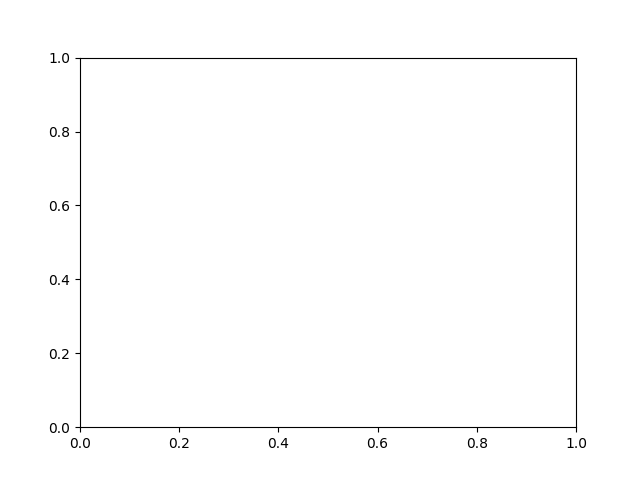

In [37]:
%matplotlib widget
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,1, 200)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#line, = ax.plot(x, pretoki_savinje[0][1][500:500+200])

def update(w = 500, dolz = 200):
    line.set_ydata(pretoki_savinje[0][1][w:w+dolz], pretoki_savinje[2][1][w:w+dolz])
    line.set_xdata(np.linspace(0, 1, dolz))
    fig.canvas.draw_idle()

interact(update);

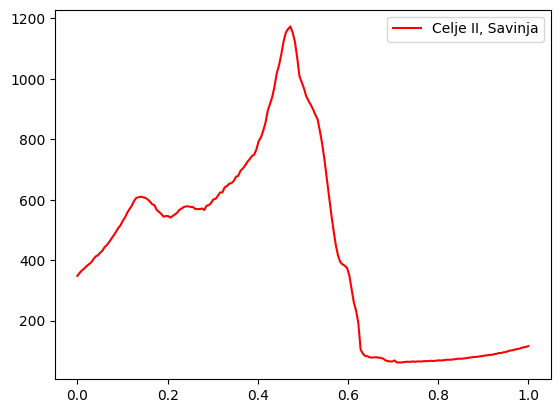

In [21]:
k=500
dolz=200
plt.plot(np.linspace(0,1, dolz), pretoki_savinje[0][1][k:k+dolz], color = "red", label = "Celje II, Savinja")
#plt.plot(np.linspace(0,1, dolz), pretoki_savinje[1][1][k:k+dolz], color = "green", label = "Celje II, Voglajna")
#plt.plot(np.linspace(0,1, dolz), pretoki_savinje[2][1][k:k+dolz], color = "aqua", label = "Laško, Savinja")
plt.legend()
plt.show()

In [22]:
plt.close()

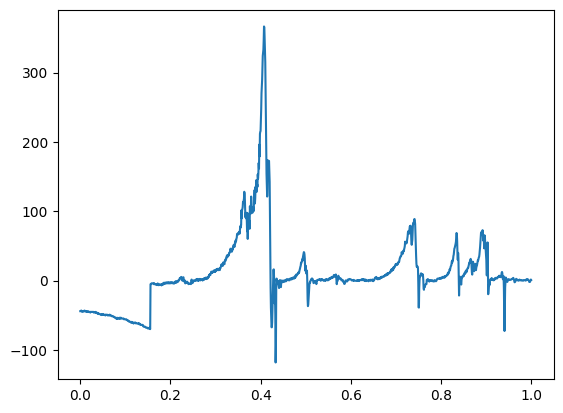

In [23]:
c = pretoki_savinje[2][1]-pretoki_savinje[0][1] - pretoki_savinje[1][1]
plt.plot(np.linspace(0,1, n), c)


In [102]:
def casovna_razlika(prvi, drugi):
    """
    Funkcija ki pogleda dva enako velika np.arraya in poskusi ugotoviti zamik med njima
    """
    konst = 0.0 
    zamik = 0
    n = len(prvi)
    if n!=len(drugi):
        RaiseException("Seznama se morata ujemati po dolžini")
        print(hmm)
    
    def kvadratna_razlika(zamik):
        """
        Izračun razlike
        prvi in drugi sta že definirana v casovna_razlika, funkcija se ne more uporabljati izven tega
        """
        if zamik>=0:
            izracun = np.sum((prvi[0:n-zamik:]-drugi[zamik::])**2/(n-zamik)**2)
            #pogledamo kvadrat razlike, ga normaliziramo, da se zmanjša vpliv tega, da je manj podatkov pri večjem zamiku, odštejemo konstanto, za katero 
        else:
            izracun = np.sum((prvi[-zamik::]-drugi[0:n+zamik:])**2/(n+zamik)**2)
            #zamik je lahko v eno ali drugo smer
        return izracun

    seznam_razlik = [kvadratna_razlika(i) for i in np.arange(-10, 11)]
    
    
    return seznam_razlik

In [103]:
casovna_razlika(pretoki_savinje[0][1], pretoki_savinje[1][1])

[31.134107236492802,
 31.099406919917843,
 31.066121254269905,
 31.03410778923391,
 31.00329400966599,
 30.97379231137021,
 30.94599372689483,
 30.920226967847285,
 30.896569897901134,
 30.874957821346293,
 30.855352071741677,
 30.92276116856446,
 30.992312946465056,
 31.063837506909955,
 31.137019603563967,
 31.211615801178883,
 31.28714487535556,
 31.363137172903954,
 31.439237529745416,
 31.51524329397476,
 31.591099705514733]

In [87]:
len(pretoki_savinje[1][1])

1439

In [90]:
len(pretoki_savinje[1][1][10::])

1429

In [91]:
len(pretoki_savinje[1][1][0:n-10:])

1429

In [96]:
(pretoki_savinje[1][1][10::]-pretoki_savinje[1][1][0:n-10:])**2

array([0.01    , 0.01    , 0.01    , ..., 0.005184, 0.      , 0.      ])

In [83]:
np.arange(-10, 11)

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10])

In [69]:
def slika(k=1, dolz = 200, ):
    n = len(pretoki_savinje[0][1])
    plt.clf()
    plt.plot(np.linspace(0,1, min(dolz, n-k)), pretoki_savinje[0][1][k:min(k+dolz, n)], label = "Celje II, Savinja")
    plt.plot(np.linspace(0,1, min(dolz, n-k)), pretoki_savinje[1][1][k:min(k+dolz, n)], label = "Celje II, Voglajna")
    plt.plot(np.linspace(0,1, min(dolz, n-k)), pretoki_savinje[2][1][k:min(k+dolz, n)], label = "Laško - Savinja")
    #plt.ylim(-5, 5)
    plt.show()

In [73]:
interact(slika, k=widgets.IntSlider(min=1, max=1400, step=1, value=500, description = "Začetek"), dolz = widgets.IntSlider(min=20, max=1400, step=1, value=200, description = "Trajanje") );

interactive(children=(IntSlider(value=500, description='Začetek', max=1400, min=1), IntSlider(value=200, descr…

In [29]:
plt.close()

In [29]:
plt.close()

In [13]:
import pandas as pd
knjige = pd.read_csv('postaje/H6200_t_30.html.csv', index_col='Datum')
knjige.title()

AttributeError: 'DataFrame' object has no attribute 'title'